In [7]:
%load_ext autoreload
%autoreload 2

from basic_vae_module import VAE
import torch
from torch.utils.data import DataLoader

from dataset import val_set
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np


In [8]:

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = VAE.load_from_checkpoint('vae-1.cpkt', map_location=device)

mean = [194.7155, 139.2602, 145.4779]
std = [36.0167, 38.9894, 43.4381]
def denormalize_image(image):
    image = image.cpu().detach().permute(1, 2, 0).numpy()
    image = image * std + mean
    image = image.astype(np.uint8)
    return image

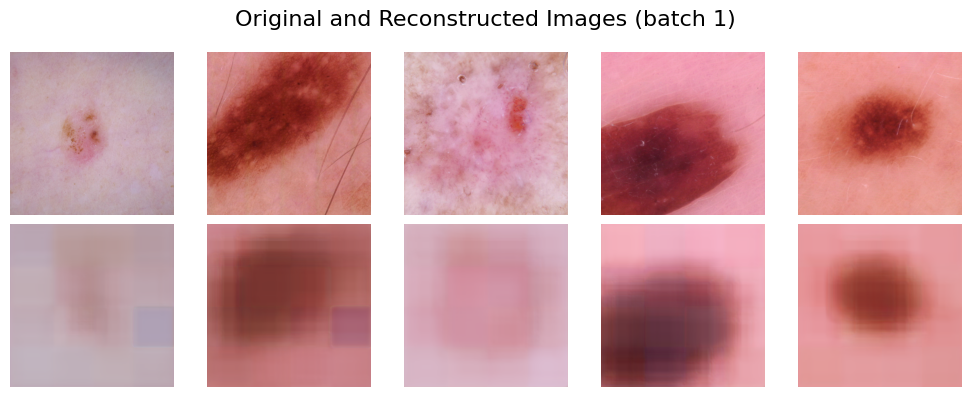

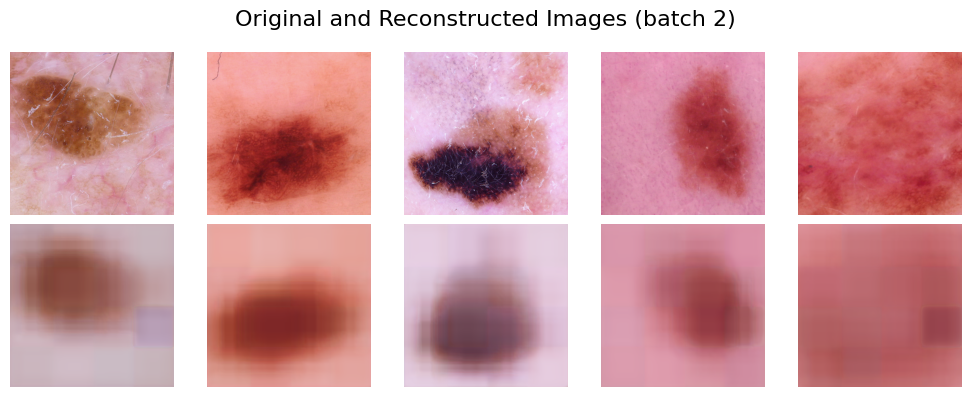

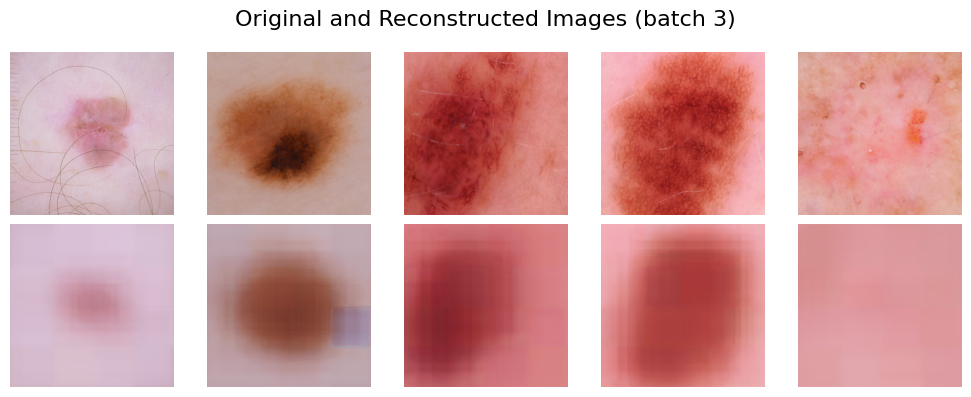

In [3]:
# Visualize some images from the validation set


val_loader = DataLoader(val_set, batch_size=5, shuffle=False, drop_last=False, num_workers=1)

counter = 1
for batch in val_loader:
    imgs, labels = batch
    imgs = imgs.to(device)
    original_imgs = imgs
    
    recon_imgs = model.forward(imgs)
    
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    
    # add original images
    for i, ax in enumerate(axes[0]):
        image = denormalize_image(original_imgs[i])
        ax.imshow(image)
        ax.axis('off')

    # add reconstructed images
    for i, ax in enumerate(axes[1]):
        image = denormalize_image(recon_imgs[i])
        ax.imshow(image)
        ax.axis('off')
        
    plt.suptitle(f"Original and Reconstructed Images (batch {counter})", fontsize=16)
    plt.tight_layout()

    plt.show()

    counter += 1
    if counter >= 4:
        break
        


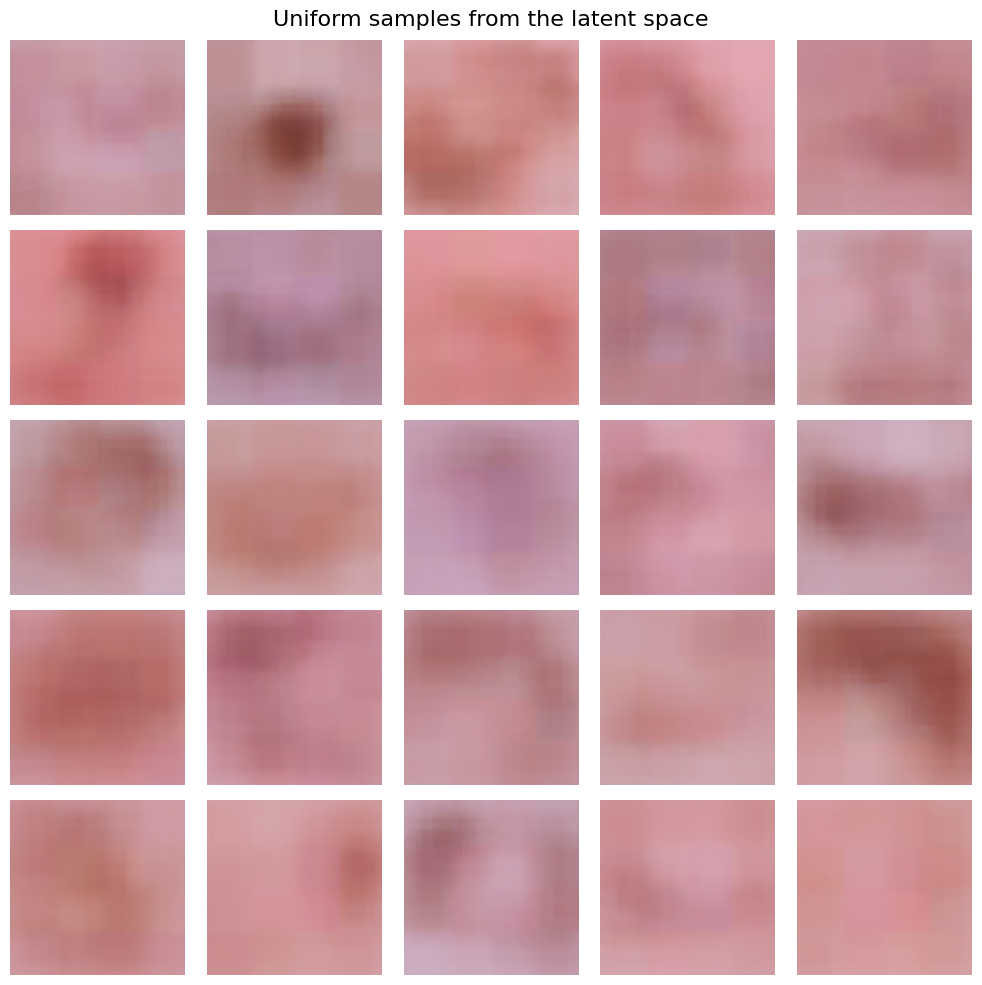

In [4]:
# Visualize random samples from the latent space

num_samples = 25

random_imgs = model.generate_samples(num_samples)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# add original images
for i, ax in enumerate(axes.flat):
    image = denormalize_image(random_imgs[i])
    ax.imshow(image)
    ax.axis('off')

plt.suptitle("Uniform samples from the latent space", fontsize=16)
plt.tight_layout()

plt.show()

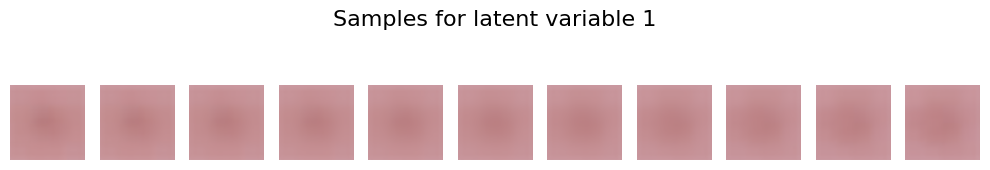

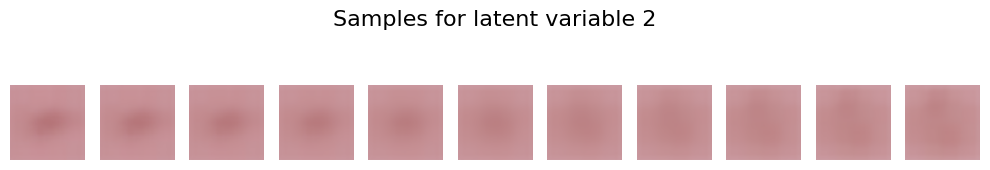

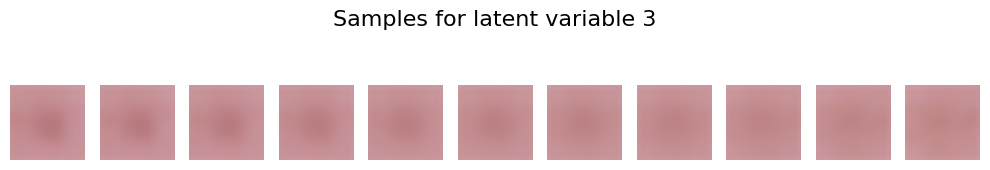

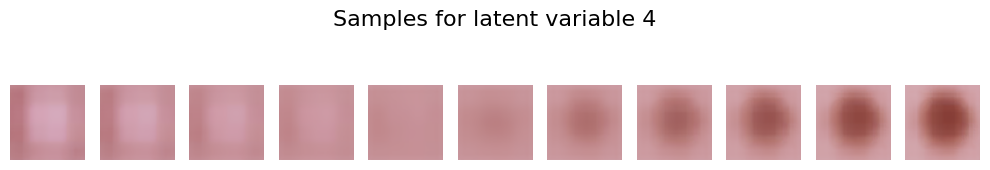

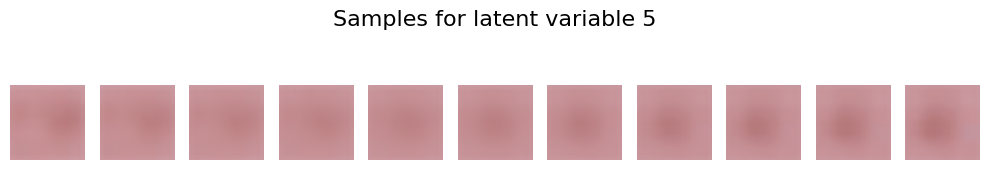

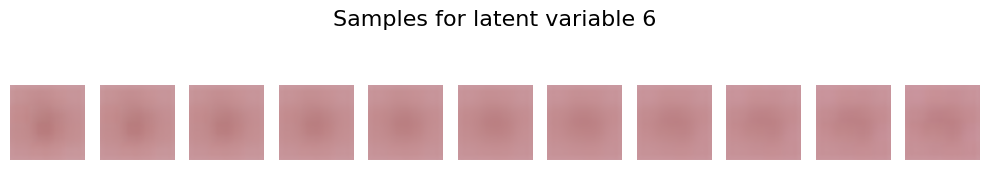

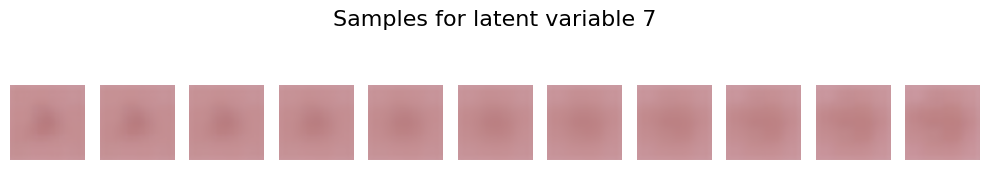

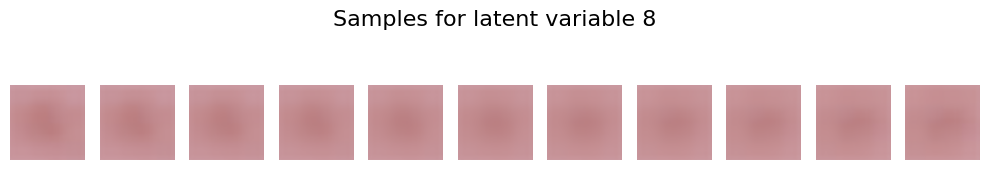

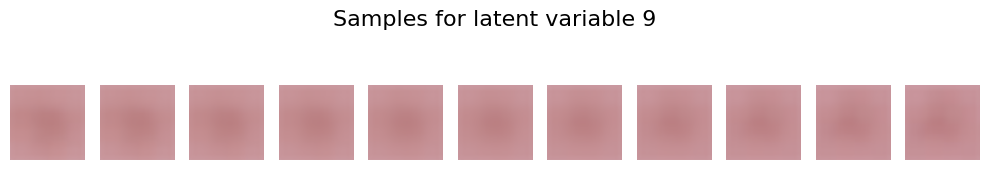

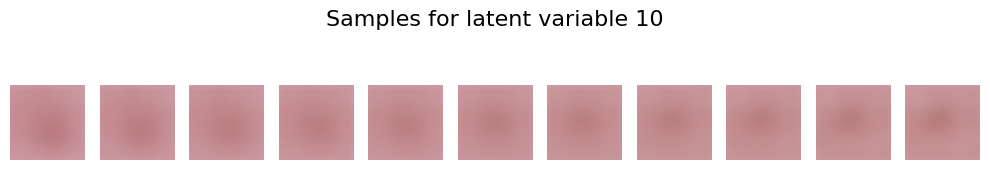

In [5]:

for i in range(10):
    
    latent_variable = i

    random_imgs = model.generate_samples_for_latent_variable(latent_variable)

    fig, axes = plt.subplots(1, 11, figsize=(10, 2))

    # add original images
    for i, ax in enumerate(axes.flat):
        image = denormalize_image(random_imgs[i])
        ax.imshow(image)
        ax.axis('off')

    plt.suptitle(f"Samples for latent variable {latent_variable + 1}", fontsize=16)
    plt.tight_layout()

    plt.show()

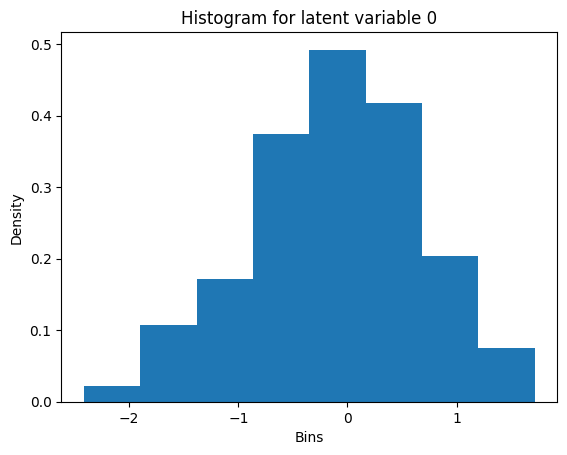

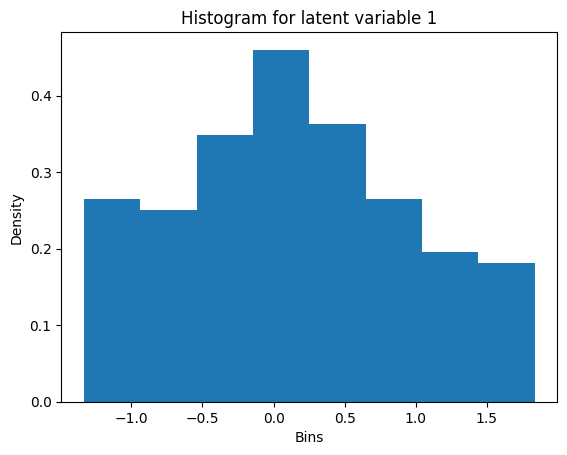

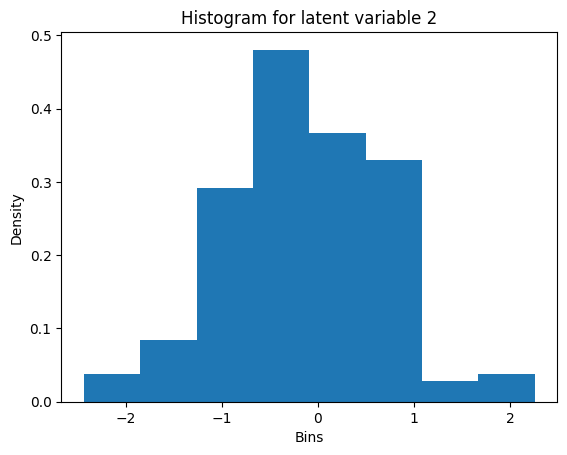

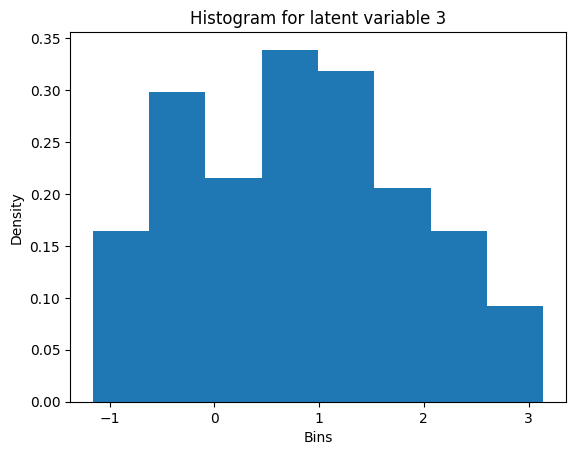

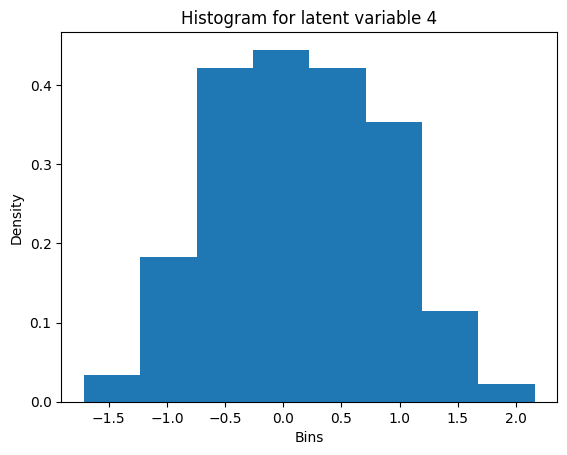

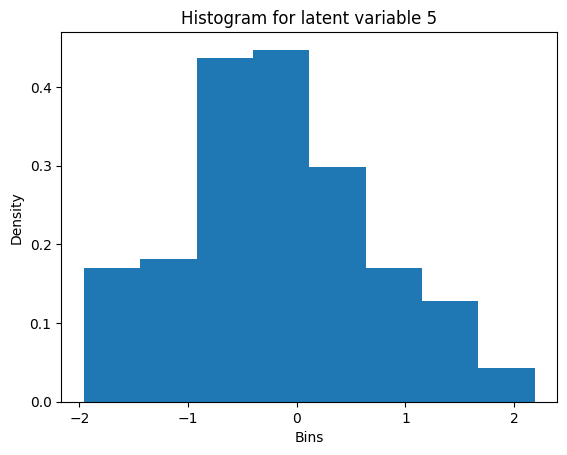

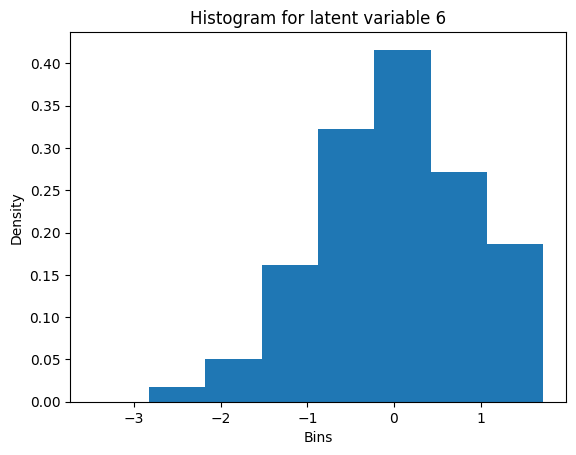

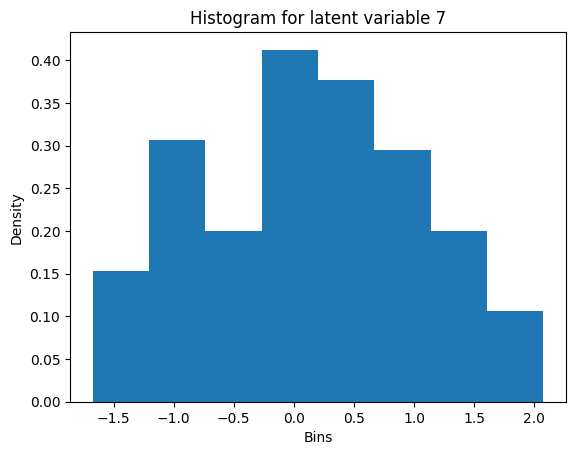

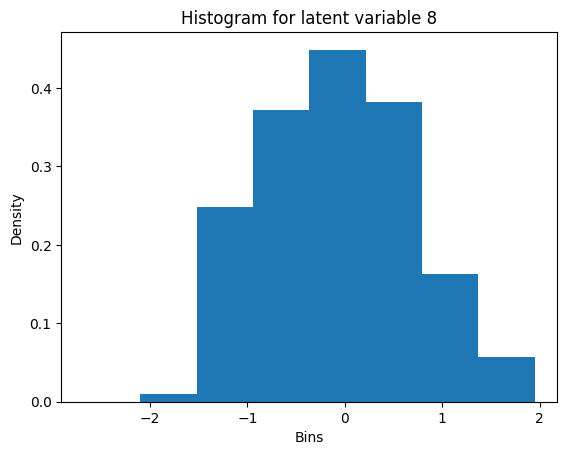

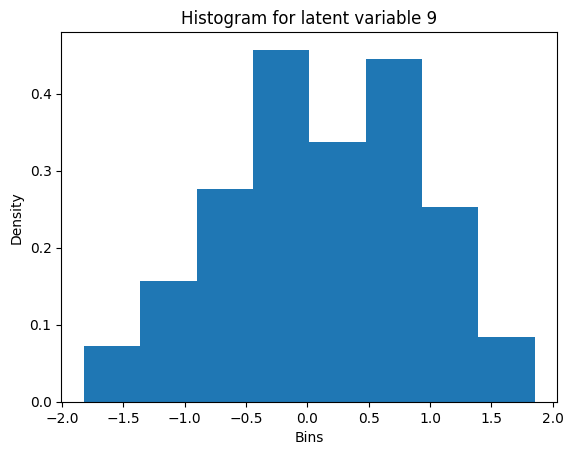

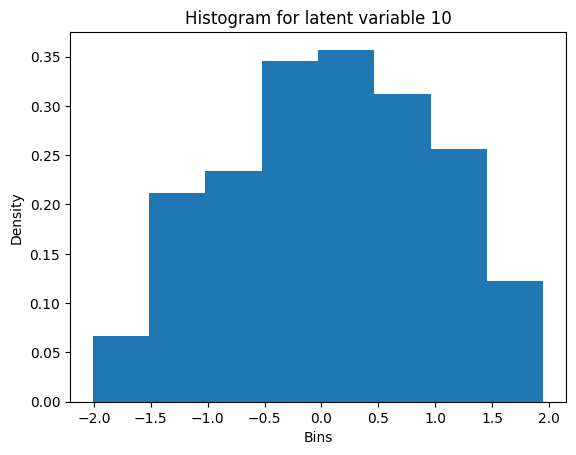

[0.00385681 0.00857069 0.00385681 0.00385681 0.00385681 0.00385681
 0.00771363 0.00771362 0.00771363 0.00385681 0.00385681 0.00771362
 0.00771362 0.00857069 0.00771362 0.00385681 0.00771362 0.00385681
 0.00385681 0.00771362 0.00385681 0.00771363 0.00192841 0.00257121
 0.00154272 0.00257121 0.00385681 0.00385681 0.00857069 0.00257121
 0.00385681 0.00771362 0.00428535 0.00385681 0.00385681 0.00385681
 0.00385681 0.00771362 0.00857069 0.00385681 0.00385681 0.00771362
 0.00257121 0.00771363 0.00385681 0.00385681 0.00385681 0.00771362
 0.00385681 0.00257121 0.00385681 0.00385681 0.00771362 0.00214267
 0.00771362 0.00857069 0.00385681 0.00771362 0.00771363 0.00257121
 0.00257121 0.00771362 0.00385681 0.0028569  0.00857069 0.00385681
 0.00385681 0.00771362 0.00385681 0.00257121 0.00771363 0.00257121
 0.00257121 0.00771362 0.00385681 0.0085707  0.00257121 0.00771362
 0.00385681 0.00771362 0.00857069 0.00771362 0.00771363 0.00857069
 0.00771362 0.00385681 0.00385681 0.00257121 0.00385681 0.0038

In [17]:
val_loader = DataLoader(val_set, batch_size=5, shuffle=False, drop_last=False, num_workers=1)

latent_repr_chunks = []
for batch in val_loader:
    imgs, labels = batch
    imgs = imgs.to(device)
    original_imgs = imgs

    chunk_latent_repr = model.encode(imgs)
    latent_repr_chunks.append(chunk_latent_repr)

latent_repr = torch.cat(latent_repr_chunks, dim=0)

training_sample_p = np.zeros(latent_repr.shape[0])
bins = 10

for i in range(256):
    latent_distribution = latent_repr[:,i].cpu()
    hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

    bin_edges[0] = -float('inf')
    bin_edges[-1] = float('inf')

    smoothing_fac = 0
    
    bin_idx = np.digitize(latent_distribution, bin_edges) 
    hist_smoothed_density = hist_density + smoothing_fac
    hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

    p = 1.0/(hist_smoothed_density[bin_idx-1])
    p = p/np.sum(p)
    training_sample_p = np.maximum(p, training_sample_p)
    
    if i <= 10:
        plt.bar(bin_edges[:-1], hist_density, width=np.diff(bin_edges), align='edge')
        plt.xlabel('Bins')
        plt.ylabel('Density')
        plt.title(f"Histogram for latent variable {i}")
        plt.show()


training_sample_p /= np.sum(training_sample_p)
print(training_sample_p)
print(np.sum(training_sample_p))
        
print(latent_repr.size())
        